# Mock making: linear power spectra and bias independant terms.

In this notebook we will make our mock galaxy power spectrum multipoles as well Gaussian covariances for these. As mentioned in `make_mocks_lin_and_loops.ipynb` these power spectra will have a Plank 2018 like cosmology, and will be calculated at $z=[0.38,0.51,0.61]$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import matryoshka.emulator as MatEmu
import matryoshka.halo_model_funcs as MatHM
import matryoshka.eft_funcs as MatEFT

As with most of the other notebooks in this repo we start by specifying the repo location.

In [2]:
path_to_repo = "/Users/jamie/Desktop/GitHubProjects/matryoshka_II_paper/"

We next specify where within the repo we would like to save the functions we are calculating here.

In [3]:
save_dir = path_to_repo+"data/P18/"

## Multipoles

We need to define some bias parameters and counterterms that we will use to compute our mock multipoles. We will use the best fit LOWZ and CMASS-NGC parameters from table 3 in [d’Amico (2019)](https://arxiv.org/abs/1909.05271). The LOWZ parameters will be used for the mock power spectrum at $z=0.38$ and the CMASS parameters will be used for the mock power spectra at $z=0.51$ and $z=0.61$. These parameters are presented in the table below.

|Redshift|$b_1$|$c_2$|$b_3$|$c_4$|$c_{ct}$|$c_{r,1}$|$c_{\epsilon,1}$|$c_q$|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|---:|---:|
|0.38|1.73|1.0|-1.0|0.0|0.2|-10.03|0.00|-2.1|
|0.51,0.61|2.22|1.2|0.1|0.0|0.4|-7.7|0.00|-3.7|

As in d'Amico (2019) we will set $c_4=0$, $c_{r,2}=0$ and $c_{\epsilon,m}=0$.

In [4]:
# b1, c2, b3, c4, cct, cr1, cr2, ce, cm, cq
bs_LOWZ = np.array([1.73, 1.0, -1.0, 0.0, 0.2, -10.03, 0., 0., 0., -2.1])
bs_CMASS = np.array([2.22, 1.2, 0.1, 0.0, 0.4, -7.7, 0., 0., 0., -3.7])

The parameters $c_2$ and $c_4$ are realted to the bias parameters $b_2$ and $b_4$ via the equations below,

$$b_2 = \frac{1}{\sqrt{2}}(c_2+c_4)\ ,$$

$$b_4 = \frac{1}{\sqrt{2}}(c_2-c_4)\ .$$

In [5]:
def c_to_b(c2, c4):
    return np.array([1/np.sqrt(2)*(c2+c4),1/np.sqrt(2)*(c2-c4)])

In [6]:
bs_LOWZ[[1,3]] = c_to_b(bs_LOWZ[1], bs_LOWZ[3])
bs_CMASS[[1,3]] = c_to_b(bs_CMASS[1], bs_CMASS[3])

In [7]:
cosmo = np.array([0.11933, 0.02242, 0.6766, 3.047, 0.9665])
ng = 3e-4
klin = np.linspace(MatEmu.kbird[:39].min(), MatEmu.kbird[:39].max(), MatEmu.kbird[:39].shape[0])

In [8]:
for i, zi in enumerate([0.38, 0.51, 0.61]):
    
    if i > 0:
        bs = bs_CMASS
    else:
        bs = bs_LOWZ

    P110 = np.load(save_dir+"z{z}/P11l/P110_P18--z-{z}_optiresum-False.npy".format(z=zi))
    Ploop0 = np.load(save_dir+"z{z}/Ploopl/Ploop0_P18--z-{z}_optiresum-False.npy".format(z=zi))
    Pct0 = np.load(save_dir+"z{z}/Pctl/Pct0_P18--z-{z}_optiresum-False.npy".format(z=zi))

    P112 = np.load(save_dir+"z{z}/P11l/P112_P18--z-{z}_optiresum-False.npy".format(z=zi))
    Ploop2 = np.load(save_dir+"z{z}/Ploopl/Ploop2_P18--z-{z}_optiresum-False.npy".format(z=zi))
    Pct2 = np.load(save_dir+"z{z}/Pctl/Pct2_P18--z-{z}_optiresum-False.npy".format(z=zi))

    f = MatHM.fN((cosmo[0]+cosmo[1])/cosmo[2]**2, zi)
    
    P0 = MatEFT.multipole([P110,Ploop0,Pct0],bs[:7],f,stochastic=bs[7:], ng=ng, multipole=0, 
                              kbins=MatEmu.kbird)[:39]
    P2 = MatEFT.multipole([P112,Ploop2,Pct2],bs[:7],f,stochastic=bs[7:], ng=ng, multipole=2, 
                              kbins=MatEmu.kbird)[:39]
    
    np.save(save_dir+"z{z}/poles/P0_P18--z-{z}_optiresum-False.npy".format(z=zi), 
            np.stack([klin, interp1d(MatEmu.kbird[:39], P0)(klin)]))
    np.save(save_dir+"z{z}/poles/P2_P18--z-{z}_optiresum-False.npy".format(z=zi), 
            np.stack([klin, interp1d(MatEmu.kbird[:39], P2)(klin)]))
    

## Gaussian covariance

Now we move onto calculating Gaussian covariance matrices to go with our mock power spectra.

To calculate these covariance matrices we will be using equations C2-C4 in [Taruya, Nishimichi, Saito (2010)](https://arxiv.org/abs/1006.0699). These are translated into Python below.

In [9]:
def C00_gauss(k, Pk, f, b, ng, deltak, Vs):
    
    beta = f/b
    Nk = (4*np.pi*k**2*deltak)/(2*np.pi/Vs**(1/3))**3
    A = (1 + 4/3*f + 6/5*beta**2 + 4/7*beta**3 + 1/9*beta**4)*(b**2*Pk)**2
    B = 2/ng*(1 + 2/3*beta + 1/5*beta**2)*b**2*Pk
    
    return 2/Nk*(A+B+1/ng**2)

def C02_gauss(k, Pk, f, b, ng, deltak, Vs):
    
    beta = f/b
    Nk = (4*np.pi*k**2*deltak)/(2*np.pi/Vs**(1/3))**3
    A = (8/3*beta + 24/7*beta**2 + 40/21*beta**3 + 40/99*beta**4)*(b**2*Pk)**2
    B = 2/ng*(4/3*beta + 4/7*beta**2)*b**2*Pk
    
    return 2/Nk*(A+B)

def C22_gauss(k, Pk, f, b, ng, deltak, Vs):
    
    beta = f/b
    Nk = (4*np.pi*k**2*deltak)/(2*np.pi/Vs**(1/3))**3
    A = (5 + 220/21*beta + 90/7*beta**2 + 1700/231*beta**3 + 2075/1287*beta**4)*(b**2*Pk)**2
    B = 2/ng*(5 + 110/21*beta + 15/7*beta**2)*b**2*Pk
    
    return 2/Nk*(A+B+5/ng**2)

In [10]:
def make_cov(C00, C22, C02):

    C00 = np.diag(C00)
    C22 = np.diag(C22)
    C02 = np.diag(C02)
        
    return np.vstack([np.hstack([C00, C02]), np.hstack([C02, C22])])

In [11]:
for i, zi in enumerate([0.38, 0.51, 0.61]):
    kk = np.load(save_dir+"z{z}/lin/Plin_P18--z-{z}.npy".format(z=zi))[0]
    Plin = np.load(save_dir+"z{z}/lin/Plin_P18--z-{z}.npy".format(z=zi))[1]
    
    Plin_int = interp1d(kk, Plin)(klin)
    
    if i > 0:
        b1 = bs_CMASS[0]
    else:
        b1 = bs_LOWZ[0]
    
    for Vi in [1000,2000,3000,3700,4000,5000]:
        
        C00 = C00_gauss(klin, Plin_int, f, b1, ng, np.diff(klin)[0], Vi**3)
        C22 = C22_gauss(klin, Plin_int, f, b1, ng, np.diff(klin)[0], Vi**3)
        C02 = C02_gauss(klin, Plin_int, f, b1, ng, np.diff(klin)[0], Vi**3)
        
        np.save(save_dir+"z{z}/covs/cov_P18--z-{z}_Vs-{V}.npy".format(z=zi, V=Vi), 
                make_cov(C00, C22, C02))

## Make figure _x_ for paper

In [12]:
P0 = np.load(save_dir+"z0.61/poles/P0_P18--z-0.61_optiresum-False.npy")[1]
P2 = np.load(save_dir+"z0.61/poles/P2_P18--z-0.61_optiresum-False.npy")[1]
cov = np.load(save_dir+"z0.61/covs/cov_P18--z-0.61_Vs-2000.npy")

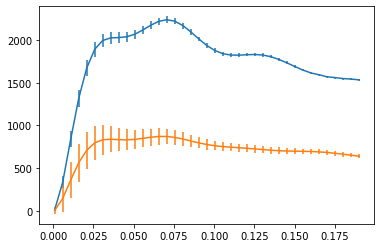

In [13]:
plt.errorbar(klin, P0*klin, yerr=np.sqrt(cov.diagonal()[:klin.shape[0]])*klin)
plt.errorbar(klin, P2*klin, yerr=np.sqrt(cov.diagonal()[klin.shape[0]:])*klin)
plt.show()